In [4]:
# first our usual bookkeeping
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (14,4)

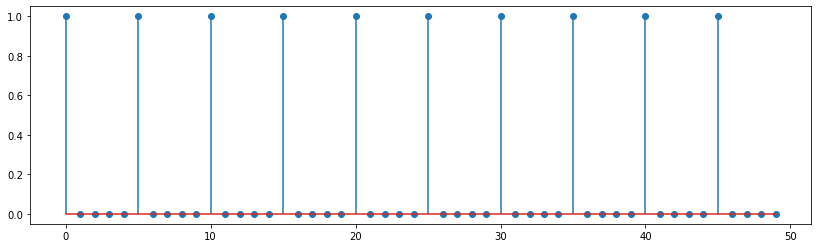

In [55]:
N = 64
n= np.arange(0,N,1)

L = N/16
y=0.5*np.sin(2*np.pi/N*L*(n-3))

y=np.array([1,0,0,0,0]*10)
# y=np.array([1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0])
# y=np.zeros(100)
# y[0:5]=1

plt.stem(y,use_line_collection=True)
plt.show()

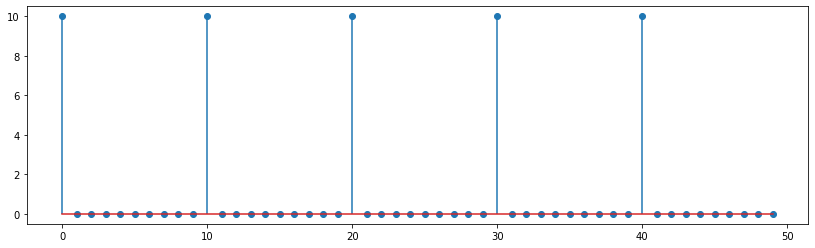

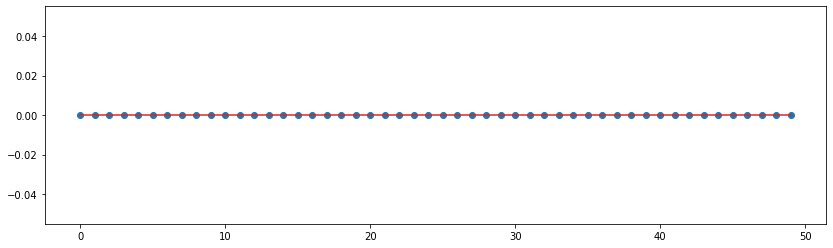

In [56]:
Y2 = np.fft.fft(y)
plt.stem(np.abs(Y2),use_line_collection=True)
plt.show()
plt.stem(np.imag(Y2),use_line_collection=True)
plt.show()

## Music example

In [116]:
import IPython
from scipy.io import wavfile
Fs, x = wavfile.read("speaker_test_sound.wav")
IPython.display.Audio(x, rate=Fs)
print("Fs = ",Fs,"\nx.shape = ",x.shape)

L=20000
x=x[:L]
X = np.fft.fft(x);

Fs =  8000 
x.shape =  (51643,)


In [117]:
def dft_shift(X):
    N = len(X)
    if (N % 2 == 0):
        # even-length: return N+1 values
        return np.arange(-int(N/2), int(N/2) + 1), np.concatenate((X[int(N/2):], X[:int(N/2)+1]))
    else:
        # odd-length: return N values
        return np.arange(-int((N-1)/2), int((N-1)/2) + 1), np.concatenate((X[int((N+1)/2):], X[:int((N+1)/2)]))

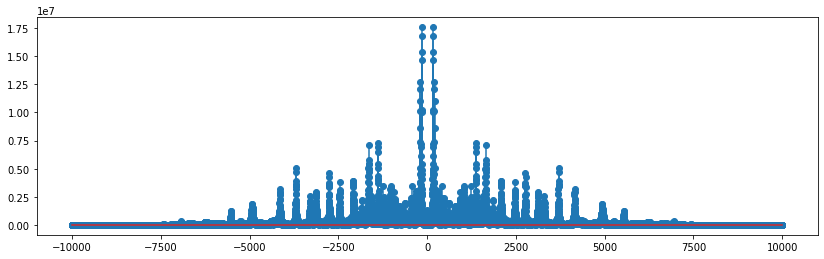

In [118]:
n, y = dft_shift(X)
plt.stem(n, abs(y),use_line_collection=True)
plt.show()

In [119]:
def dft_map(X, Fs, shift=True):
    resolution = float(Fs) / len(X)
    if shift:
        n, Y = dft_shift(X)
    else:
        Y = X
        n = np.arange(0, len(Y))
    f = n * resolution
    return f, Y

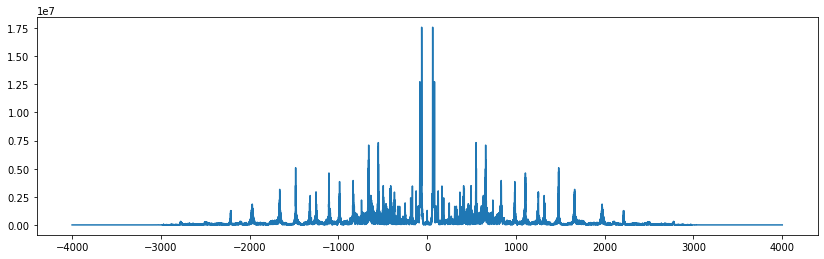

In [120]:
f, y = dft_map(X, Fs)
plt.plot(f, abs(y));

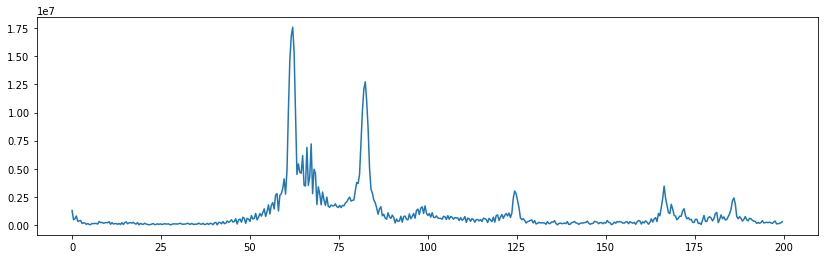

In [121]:
window = 500
X = np.fft.fft(x);
f, y = dft_map(X, Fs, shift=False)
plt.plot(f[:window], abs(y[:window]));

In [123]:
dft_resolution = float(Fs)/ len(x)
print("DFT resolution is", dft_resolution, "Hz")

# let's search up to 300Hz
max_range = int(300 / dft_resolution)
ix = np.argmax(abs(y[:max_range]))
pitch = f[ix]
print("the note has a pitch of", pitch, "Hz")

DFT resolution is 0.4 Hz
the note has a pitch of 62.0 Hz


# The DFT: Numerical Aspects

In this notebook we will look at some numerical issues associated to the DFT; in particular we we will look at the differences in precision between the "naive" way of computing the DFT and the FFT algorithm.
 
As a quick reminder, the definitions of the direct and inverse DFT for a length-$N$ signal are:

\begin{align*}
    X[k] &= \sum_{n=0}^{N-1} x[n]\, e^{-j\frac{2\pi}{N}nk}, \quad k=0, \ldots, N-1 \\
    x[n] &= \frac{1}{N}\sum_{k=0}^{N-1} X[k]\, e^{j\frac{2\pi}{N}nk}, \quad n=0, \ldots, N-1
\end{align*}

The DFT produces a complex-valued vector that we can represent either via its real and imaginary parts or via its magnitude $|X[k]|$ and phase $\angle X[k] = \arctan \frac{\text{Im}\{X[k]\}}{\text{Re}\{X[k]\}}$.

## Direct Implementation

### Numerical errors in real and imaginary parts

The DFT can be easily implemented using the change of basis matrix ${W}_N$. This is an $N\times N$ complex-valued matrix whose elements are 

$$
    {W}_N(n,k)=e^{-j\frac{2\pi}{N}nk}
$$

so that the DFT of a vector $\mathbf{x}$ is simply $\mathbf{X} = W_N\mathbf{x}$. Note that the inverse DFT can be obtained by simply conjugating ${W}_N$ so that $\mathbf{x} = W_N^*\mathbf{X}$.

We can easily generate the matrix ${W}_N$ in Python like so:

In [124]:
def dft_matrix(N):
    # create a 1xN matrix containing indices 0 to N-1
    a = np.expand_dims(np.arange(N), 0)
    
    # take advantage of numpy broadcasting to create the matrix
    W = np.exp(-2j * (np.pi / N) * (a.T * a))
    
    return W

In [145]:
x = np.array([5, 7, 9,5,7,9])

# DFT matrix
N = len(x)
W = dft_matrix(N);

# DFT
X = np.dot(W, x)

# inverse DFT
x_hat = np.dot(W.T.conjugate(), X) / N

print("difference:",x-x_hat)

difference: [-3.55271368e-15+1.24344979e-14j  5.32907052e-15+2.66453526e-15j
  5.32907052e-15-7.40148683e-17j  8.88178420e-16-4.44089210e-16j
 -8.88178420e-16-1.25611693e-15j -3.55271368e-15-7.84344021e-15j]


### Numerical errors in phase

Let's first define a more interesting signal such as a length-128 step signal: 

$$
    x[n] = \begin{cases}
            1 & \mbox{for $0 \leq n < 64$} \\
            0 & \mbox{for $64 \leq n < 128$}
        \end{cases}
$$

Conveniently, we can compute its DFT analytically (it's just a geometric series) and we have 

$$
    X[k] = \begin{cases}
            64 & \mbox{for $k=0$} \\
            0 & \mbox{for $k \neq 0$, $k$ even} \\
            \frac{(-1)^{(k-1)/2}\,e^{-j\pi\frac{63}{128}k}}{\sin(\frac{\pi}{128}k)} & \mbox{for $k$ odd}
        \end{cases}
$$

From this it's easy to compute the phase; we will set its value to zero whenever the magnitude is zero (i.e. for even-indexed values) and we have

$$
    \angle X[k] = \begin{cases}
            0 & \mbox{for $k$ even} \\
            -\pi + \frac{\pi}{128}k & \mbox{for $k$ odd}
        \end{cases}
$$

However, let's see what happens if we compute all of this numerically:

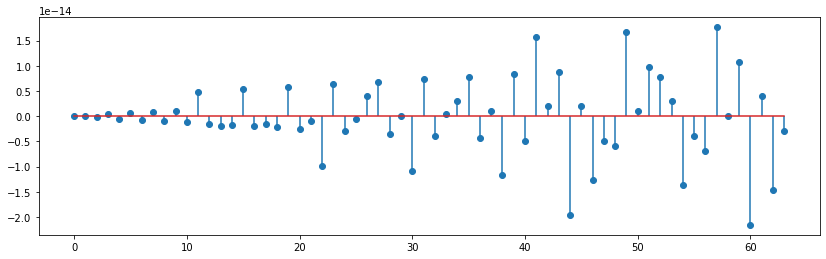

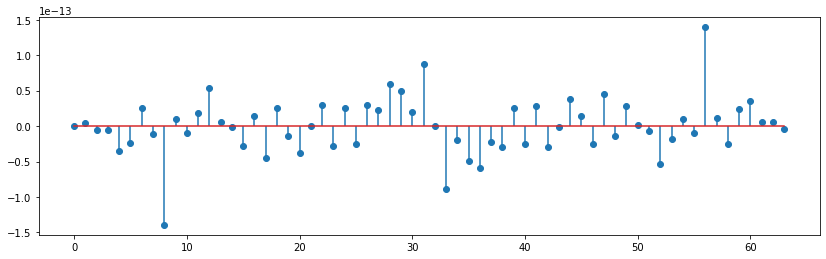

In [147]:
N = 64
n= np.arange(0,N,1)

M = N
L = N/2

y=np.sin(2*np.pi/M*L*n)
plt.figure(1)
plt.stem(y,use_line_collection=True)
plt.show()

Y2 = np.fft.fft(y)
plt.figure(2)
plt.stem(np.imag(Y2),use_line_collection=True)
plt.show()

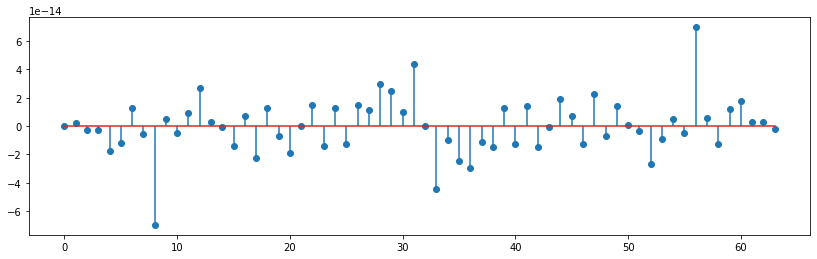

In [148]:
y=0.5*np.sin(2*np.pi/M*L*n)
Y2 = np.fft.fft(y)
plt.stem(np.imag(Y2),use_line_collection=True)
plt.show()

<StemContainer object of 3 artists>

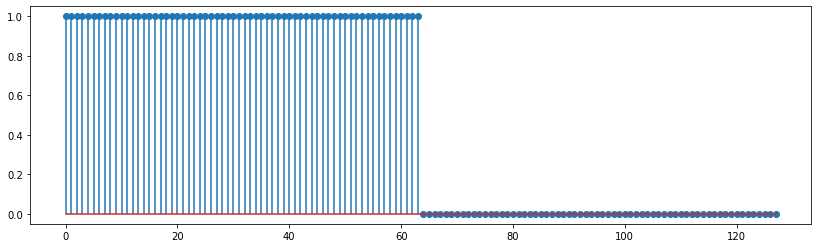

In [149]:
N = 128
x = np.zeros(N)
x[0:64] = 1

plt.stem(x,use_line_collection=True)

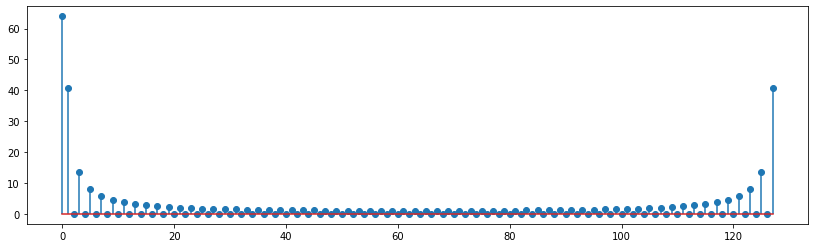

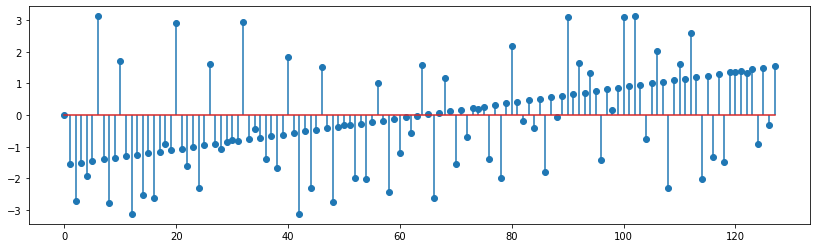

In [150]:
W = dft_matrix(N);

# DFT
X = np.dot(W, x)
plt.stem(abs(X),use_line_collection=True);
plt.show();

plt.stem(np.angle(X),use_line_collection=True);

Clearly we have a problem with the phase, although the magnitude looks nice. This is inherent to the fact that the phase is computed by taking the arctangent of a ratio. When the computed DFT values are close to zero, the denominator of the ratio will be also close to zero and any numerical error in its value will lead to large errors in the phase. As we will see in the next section, this problem can be alleviated by using smarter algorithms than the direct naive method.

Let's still verify the inverse DFT:

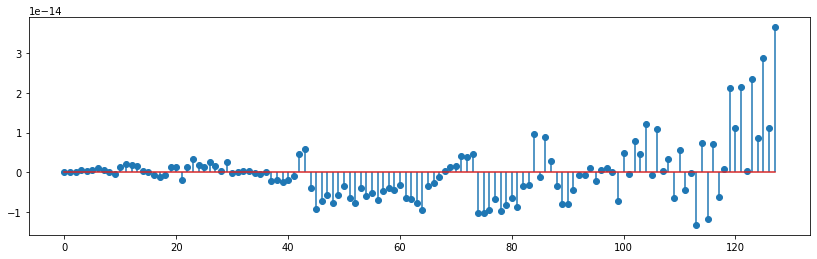

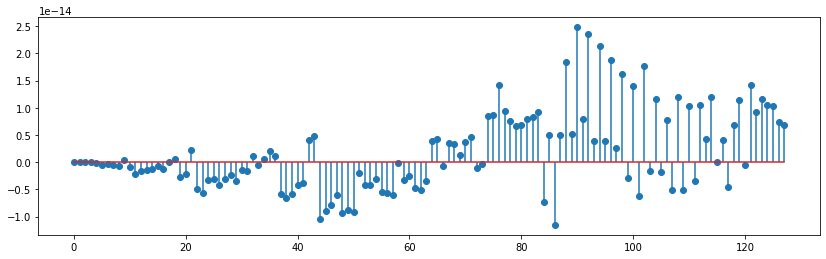

In [159]:
x_hat = np.dot(W.T.conjugate(), X) / N

plt.stem(np.real(x_hat - x),use_line_collection=True);
plt.show();
plt.stem(np.imag(x_hat),use_line_collection=True);

Again, the error is in the phase is still very large.

## The FFT Algorithm

不但快，而且数值稳定。

the phase is now accurate and the reconstruction error is almost two orders of magnitude smaller, basically equal to the numerical precision of floating point variables. 

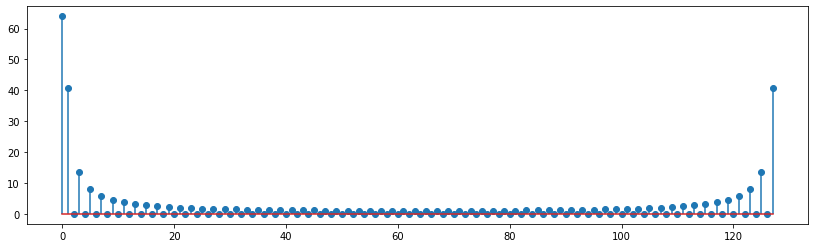

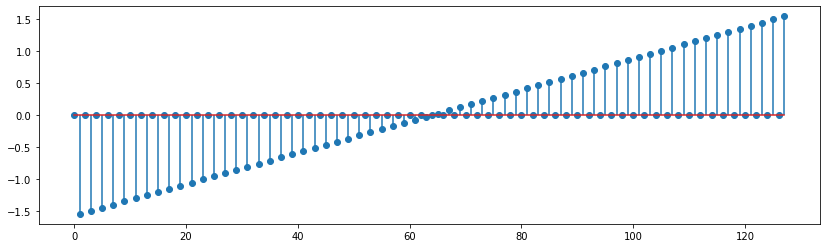

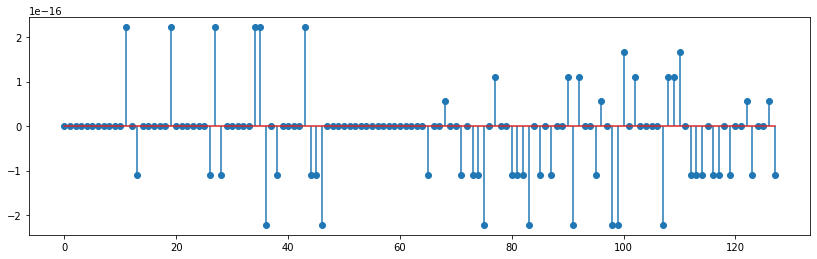

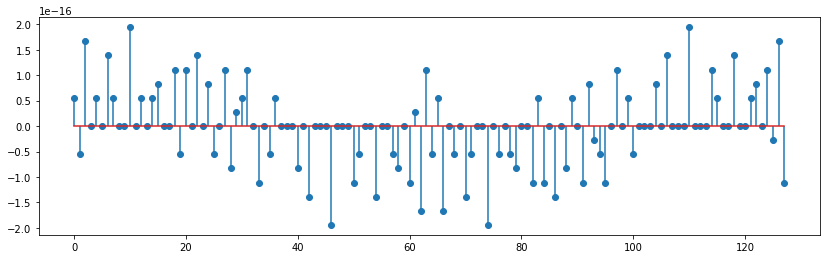

In [161]:
X = np.fft.fft(x)
x_hat = np.fft.ifft(X)

plt.stem(np.abs(X),use_line_collection=True);
plt.show();

plt.stem(np.angle(X),use_line_collection=True);
plt.show();

plt.stem(np.real(x_hat - x),use_line_collection=True);
plt.show();

plt.stem(np.imag(x_hat),use_line_collection=True);
plt.show();